In [38]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans, AgglomerativeClustering

The git repo link for this project is [Github repo](https://github.com/asankaran35/DTSA-5510-Final-Project/tree/main).

A humanitarian nonprofit has raised upwards of 10 million dollars for providing aid to people in impoverished countries that have seen natural disasters and various calamities. The task at hand is to figure out how to effectively use the 10 million dollars. Specifically, the decision is to choose the countries that are in the direst need of this aid. Using a dataset that has various socioeconomic factors as features for numerous countries, this EDA study will both categorize those countries and then suggest the countries that need the most help. The categorization of the countries will be done using unsupervised clustering algorithm(s).

In [4]:
DATA_DIR = "/kaggle/input/unsupervised-learning-on-country-data/Country-data.csv"
country_df = pd.read_csv(DATA_DIR)
print(country_df.head(5))
print("*********")
print(country_df.shape)
print("*********")

DATA_DICT_DIR = "/kaggle/input/unsupervised-learning-on-country-data/data-dictionary.csv"
data_mapping = pd.read_csv(DATA_DICT_DIR)
print(data_mapping)

               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200  
*********
(167, 10)
*********
  Column Name                                        Description
0     country                                Name of the country
1  child_mort  Death of children under 5 years of age per 100...
2     exports  Exports of goods and services per capita. Give...
3      

The dataset has 167 rows and 10 columns: 167 countries and 9 socioeconomic factors (one column is the country name). Descriptions of each factor along with their corresponding data types are mentioned in a separate .csv file and are summarized below.

1. **country**: Country name (string)
2. **child_mort**: Death of children under 5 years of age per 1000 live births (float)
3. **exports**: Exports of goods and services per capita. Given as %age of the GDP per capita (float)
4. **health**: Total health spending per capita. Given as %age of GDP per capita (float)
5. **imports**: Imports of goods and services per capita. Given as %age of the GDP per capita (float)
6. **income**: Net income per person (integer)
7. **inflation**: The measurement of the annual growth rate of the Total GDP (float)
8. **life_expec**: The average number of years a new born child would live if the current mortality patterns are to remain the same (float)
9. **total_fer**: The number of children that would be born to each woman if the current age-fertility rates remain the same (float)
10. **gdpp**: The GDP per capita. Calculated as the Total GDP divided by the total population. (integer)

Below are visualizations for the factors.

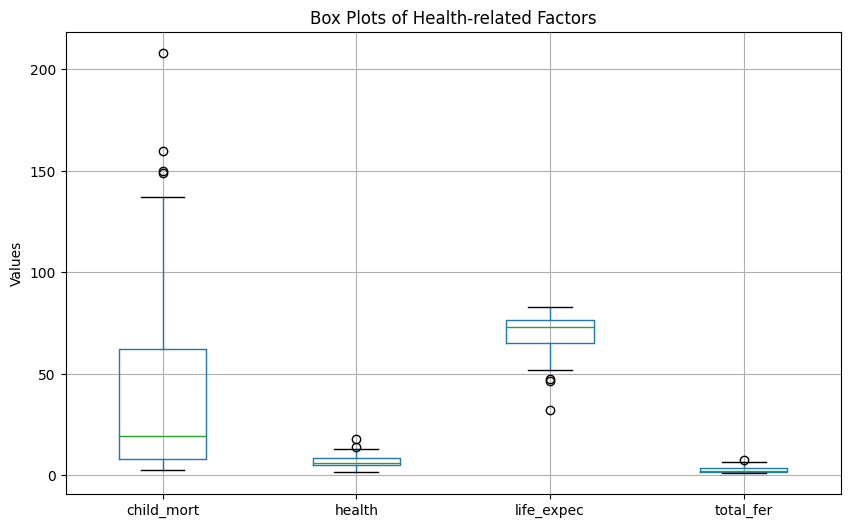

In [3]:
# Boxplots for health-related factors
plt.figure(figsize=(10, 6))
country_df.boxplot(column=['child_mort', 'health', 'life_expec', 'total_fer'])
plt.title('Box Plots of Health-related Factors')
plt.ylabel('Values')
plt.show()

Looking at the above boxplots, there are few outliers outside the respective interquartile (IQR) ranges for all the columns. Because these are very domain-specific results that would require a domain expert to identify whether these outliers are in fact real noise, I will not remove any of them.

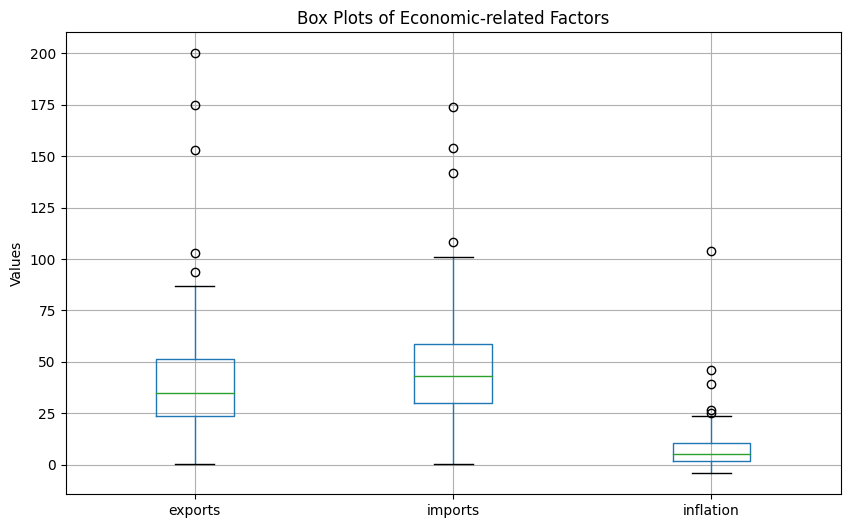

In [4]:
# Boxplots for economic-related factors
plt.figure(figsize=(10, 6))
country_df.boxplot(column=['exports', 'imports', 'inflation'])
plt.title('Box Plots of Economic-related Factors')
plt.ylabel('Values')
plt.show()

Looking at the above boxplots, there are a lot of outliers outside the respective interquartile (IQR) ranges for all the columns. Because these are very domain-specific results that would require a domain expert to identify whether these outliers are in fact real noise, I will not remove any of them.

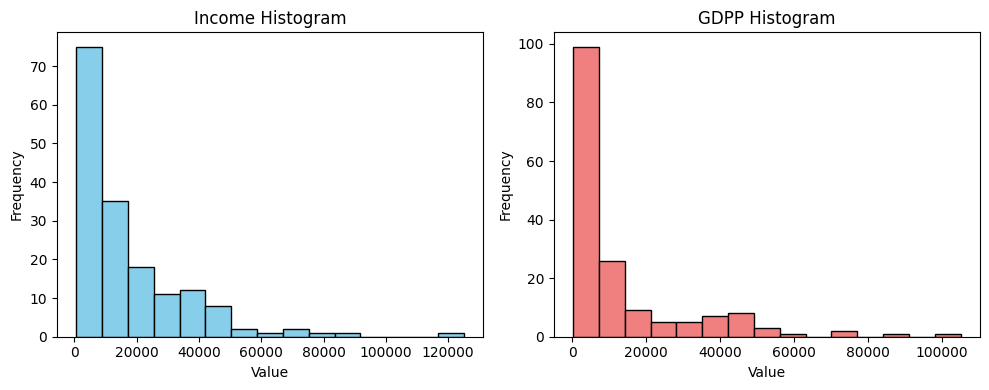

In [5]:
# Create a figure and a set of subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 4)) # figsize adjusts the figure size

# Plot the first histogram on the first axis (axes[0])
axes[0].hist(country_df['income'], bins=15, color='skyblue', edgecolor='black')
axes[0].set_title('Income Histogram')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')

# Plot the second histogram on the second axis (axes[1])
axes[1].hist(country_df['gdpp'], bins=15, color='lightcoral', edgecolor='black')
axes[1].set_title('GDPP Histogram')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()

Both histograms are right-skewed. This is indicative of factors like income and GDP where the frequency of higher values will be lower.

Now I will assess correlations between all the factors except the country name with a correlation matrix.

<Axes: >

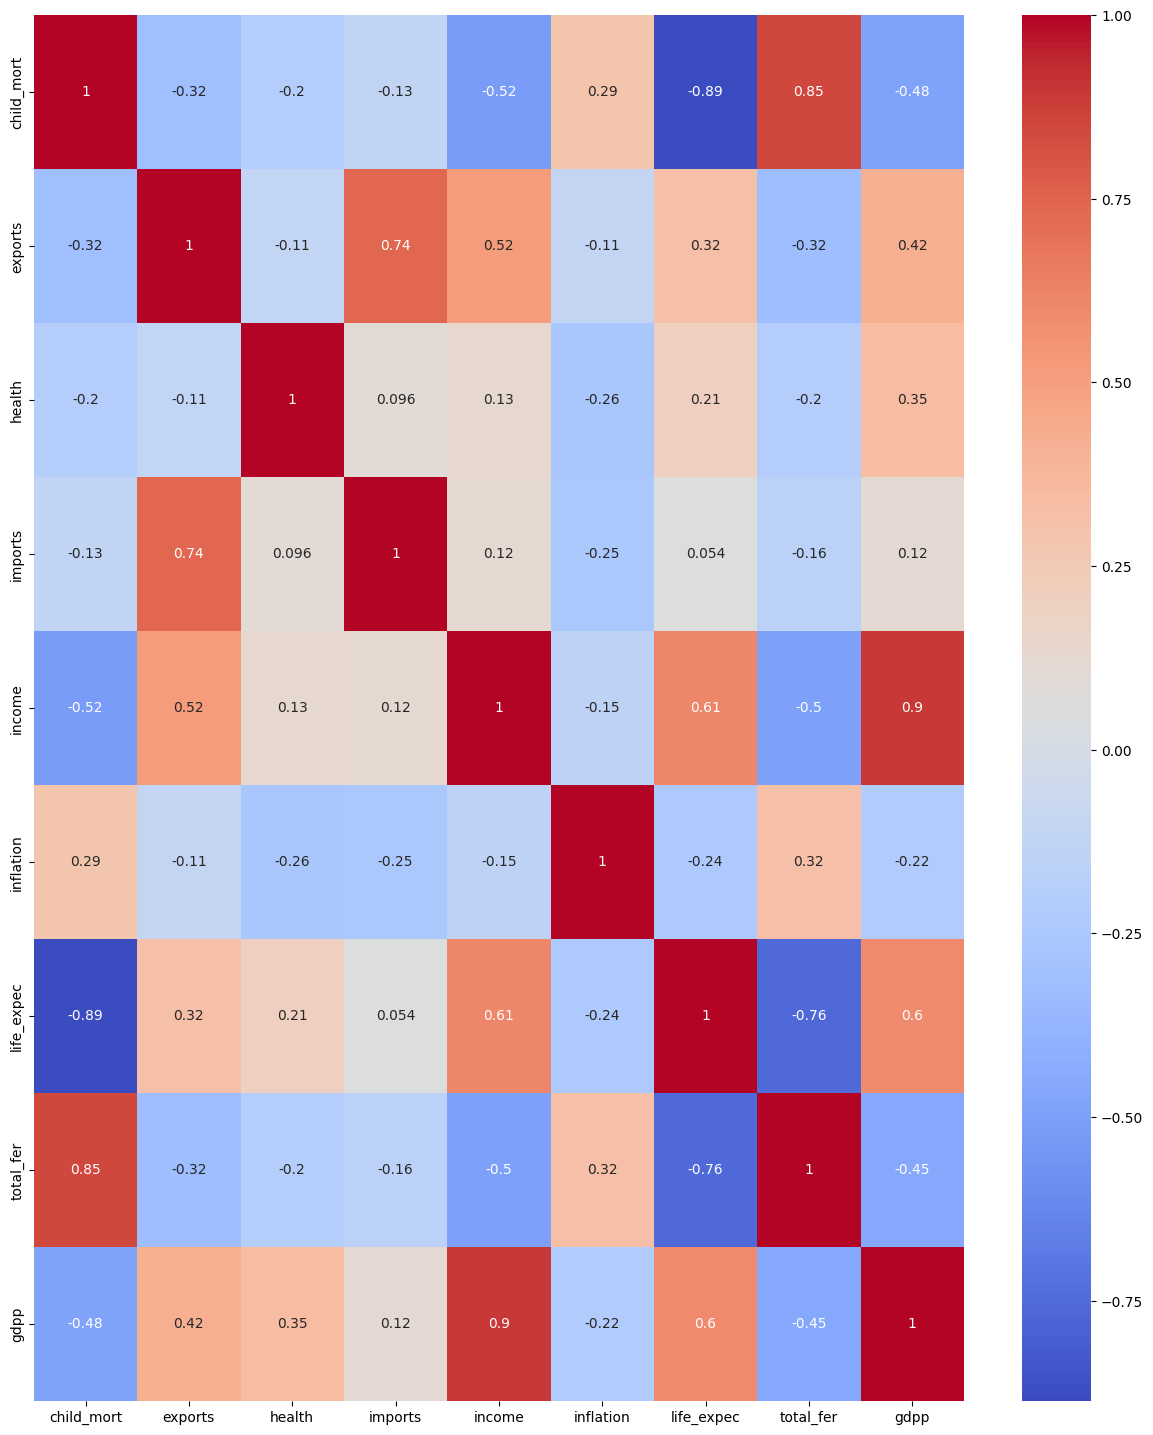

In [27]:
matrix_df = country_df.drop(columns=['country'])
fig, ax = plt.subplots(figsize=(15, 18))
sns.heatmap(matrix_df.corr(), annot = True, ax=ax, cmap='coolwarm')

In the above correlation heatmap, there is high positive correlation with related factors like income and gdpp. There is also high positive correlation with total_fer and child_mort as well as imports and exports.

The factors that I think will be the most important for the unsupervised learning will be income and gdpp based on the high correlation between each other.

Next, I will check the dataset for any missing/null values and any duplicate entries.

In [7]:
# Check if there are any null entries.
total_nan_count = country_df.isnull().sum().sum()
print("Total null entries: ", total_nan_count)
assert total_nan_count == 0

# Check if there are duplicate rows.
duplicates = country_df.duplicated()
print("Total duplicates: ", duplicates.sum())

Total null entries:  0
Total duplicates:  0


There are no null entries nor any duplicate rows. Also, based on the visualizations for all the factors, there is no transformation of the data that is required. I will now begin the unsupervised training of the data using the k means clustering algorithm. Lets set k equal to 5 to start out with.

In [7]:
kmeans_five = KMeans(n_clusters=5, random_state=42, n_init='auto')
kmeans_five.fit(matrix_df)

labels = kmeans_five.labels_  # Cluster label for each data point
centroids = kmeans_five.cluster_centers_  # Coordinates of the cluster centroids

Lets print out each cluster and the points corresponding to each one. I said before the training process that income and gdpp are the two most important features that I believe will determine how sufficient or how in need of help a country is.

In [36]:
unique_clusters = np.unique(labels)

for cluster_id in unique_clusters:
    print(f"Cluster {cluster_id}:")
    # Select data points where the label matches the current cluster_id
    cluster_points = country_df[labels == cluster_id][['country', 'income', 'gdpp']]
    print(cluster_points)
    print("-" * 20) # Separator for better readability

Cluster 0:
         country  income  gdpp
0    Afghanistan    1610   553
1        Albania    9930  4090
3         Angola    5900  3530
6        Armenia    6700  3220
12    Bangladesh    2440   758
..           ...     ...   ...
161   Uzbekistan    4240  1380
162      Vanuatu    2950  2970
164      Vietnam    4490  1310
165        Yemen    4480  1310
166       Zambia    3280  1460

[85 rows x 3 columns]
--------------------
Cluster 1:
                  country  income   gdpp
7               Australia   41400  51900
8                 Austria   43200  46900
15                Belgium   41100  44400
23                 Brunei   80600  35300
29                 Canada   40700  47400
44                Denmark   44000  58000
53                Finland   39800  46200
73                Ireland   45700  48700
82                 Kuwait   75200  38500
110           Netherlands   45500  50300
114                Norway   62300  87800
133             Singapore   72100  46600
144                Sweden   4

Based on the above results, a few of the clusters have many countries in it. Hence, there is a lot of similarity in those few clusters. This is not an effective model to select the countries that require aid because the intra-similarity amoung groups is very high. Lets increase the number of clusters to 10 and see if it makes it easier.

In [37]:
kmeans_ten = KMeans(n_clusters=10, random_state=42, n_init='auto')
kmeans_ten.fit(matrix_df)

labels = kmeans_ten.labels_  # Cluster label for each data point
centroids = kmeans_ten.cluster_centers_  # Coordinates of the cluster centroids

unique_clusters = np.unique(labels)

for cluster_id in unique_clusters:
    print(f"Cluster {cluster_id}:")
    # Select data points where the label matches the current cluster_id
    cluster_points = country_df[labels == cluster_id][['country', 'income', 'gdpp']]
    print(cluster_points)
    print("-" * 20) # Separator for better readability

Cluster 0:
         country  income  gdpp
0    Afghanistan    1610   553
3         Angola    5900  3530
6        Armenia    6700  3220
12    Bangladesh    2440   758
17         Benin    1820   758
..           ...     ...   ...
161   Uzbekistan    4240  1380
162      Vanuatu    2950  2970
164      Vietnam    4490  1310
165        Yemen    4480  1310
166       Zambia    3280  1460

[65 rows x 3 columns]
--------------------
Cluster 1:
           country  income   gdpp
7        Australia   41400  51900
8          Austria   43200  46900
15         Belgium   41100  44400
29          Canada   40700  47400
44         Denmark   44000  58000
53         Finland   39800  46200
73         Ireland   45700  48700
110    Netherlands   45500  50300
144         Sweden   42900  52100
159  United States   49400  48400
--------------------
Cluster 2:
            country  income   gdpp
42           Cyprus   33900  30800
54           France   36900  40600
58          Germany   40400  41800
68          Icel

Increasing the number of clusters to 10 helps reduce the intra-similarity by a solid margin, but there is still a somewhat high amount of it in some of the groups. I can conclude that k means clustering isn't the most effective algorithm for identifying cluster groups of similar countries. Lets apply hierarchical clustering algorithm on the dataset.

In [49]:
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=300, linkage='single', metric='euclidean')
clustering.fit(matrix_df)

# Get cluster labels
labels = clustering.labels_

unique_clusters = np.unique(labels)
for cluster_id in unique_clusters:
    print(f"Cluster {cluster_id}:")
    # Get indices of points belonging to the current cluster
    points_in_cluster = country_df[labels == cluster_id][['country', 'income', 'gdpp']]
    print(points_in_cluster)
    print("-" * 20)

Cluster 0:
                    country  income  gdpp
20   Bosnia and Herzegovina    9720  4610
34                    China    9530  4560
46                  Ecuador    9350  4660
154            Turkmenistan    9940  4440
--------------------
Cluster 1:
       country  income  gdpp
6      Armenia    6700  3220
57     Georgia    6730  2960
62   Guatemala    6710  2830
105    Morocco    6440  2830
--------------------
Cluster 2:
                      country  income  gdpp
0                 Afghanistan    1610   553
12                 Bangladesh    2440   758
17                      Benin    1820   758
25               Burkina Faso    1430   575
26                    Burundi     764   231
27                   Cambodia    2520   786
31   Central African Republic     888   446
32                       Chad    1930   897
36                    Comoros    1410   769
37           Congo, Dem. Rep.     609   334
50                    Eritrea    1420   482
56                     Gambia    1660   56

# clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=300, linkage='single', metric='euclidean')
With these parameters, the number of clusters that were created is 114. The ideal number of clusters would be close to half the number of rows in the dataset: 0.5 * 167 ~ 84. The distance_threshold would need to be tweaked to achieve this. The linkage metric should be 'single' because the priority is grouping together countries with lower metrics like income and gdp.

In [52]:
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=750, linkage='single', metric='euclidean')
clustering.fit(matrix_df)

# Get cluster labels
labels = clustering.labels_

unique_clusters = np.unique(labels)
for cluster_id in unique_clusters:
    print(f"Cluster {cluster_id}:")
    # Get indices of points belonging to the current cluster
    points_in_cluster = country_df[labels == cluster_id][['country', 'income', 'gdpp']]
    print(points_in_cluster)
    print("-" * 20)

Cluster 0:
         country  income  gdpp
3         Angola    5900  3530
6        Armenia    6700  3220
18        Bhutan    6420  2180
19       Bolivia    5410  1980
30    Cape Verde    5830  3310
38   Congo, Rep.    5190  2740
48   El Salvador    7300  2990
52          Fiji    7350  3650
57       Georgia    6730  2960
62     Guatemala    6710  2830
65        Guyana    5840  3040
70     Indonesia    8430  3110
103     Mongolia    7710  2650
105      Morocco    6440  2830
113      Nigeria    5150  2330
118     Paraguay    7290  3230
120  Philippines    5600  2130
127        Samoa    5400  3450
140    Sri Lanka    8560  2810
151        Tonga    4980  3550
156      Ukraine    7820  2970
--------------------
Cluster 1:
     country  income  gdpp
16    Belize    7880  4340
76   Jamaica    8000  4680
108  Namibia    8460  5190
--------------------
Cluster 2:
     country  income   gdpp
67   Hungary   22300  13100
121   Poland   21800  12600
--------------------
Cluster 3:
       country  inc

Setting the distance threshold to 750 yielded the above clusters. Out of the 83 total clusters, only 3 of them have more than 3 countries in them: Cluster 0, 5, and 7. All other clusters have 3 or less countries. Here is some additional analysis of the clusters 0, 5, and 7.

1. Cluster 0: income range is mostly between 5000 - 9000 and gdpp range is mostly between 2000 - 4000.
2. Cluster 5: income range is mostly between 9000 - 10000 and gdpp range is mostly between 4000 - 5000.
3. Cluster 7: income range is mostly between 500 - 4500 and gdpp range is mostly between 200 - 1500.

Looking at the approximate ranges of these 3 major clusters, there is little overlap between the values for the income and gdpp factors. All other clusters have countries with metrics that are different from each other and hence, most of the clusters consist of few countries ranging from 1 to 3.

**Conclusion**

Out of all the models and clustering algorithms conducted, the hierarchical clustering with the distance threshold set to 750 is the most effective one to use for the purpose of this study. A nonprofit like the one in this study would prioritize the countries in clusters 0,5, and 7 for the aid relief.